In [27]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt
import cv2
from matplotlib import image
import os
import numpy as np
from scipy import ndimage
from scipy.ndimage import morphology
import mach_functions


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
def runFiltering(yamlFile):
    """
    Read in the parameters in the yamlFile and run the hierarchical filtering 
    """
    # load in parmeters
    Params = mach_functions.load_yaml(yamlFile)
    Filters = mach_functions.readInfilters(Params)
    Images = mach_functions.readInImages(Params)

    detectedCells = dict()
    if Params['PenaltyFilterOption'] == 1:
        print ("using the 'rodp' as penalty filter for rod cell detection")
        penaltyFilter = Filters['PenaltyFilters']['rodp']
        penaltyThres = Params['ThresValues']['rodp']
    else:
        print ("using the 'rrodp' as penalty filter for rod cell detection")
        penaltyFilter = Filters['PenaltyFilters']['rrodp']
        penaltyThres = Params['ThresValues']['rrodp']
    
    # detect rod and remove the cells in the test image
    print ("Detecting the rod cells ---")
    detectedCells['rod'] = mach_functions.Rodrotate(Images['grayImage'],\
                                   Filters['NormalFilters']['rod'],\
                                   penaltyFilter,\
                                   Params['ThresValues']['rod'],\
                                   penaltyThres)
    newtestImage = mach_functions.removeDetectedCells(Images['grayImage'],detectedCells['rod'],bgmthres=0.4)

    # detect ram and hyp
    print ("Detecting the ram/hyp cells ---")
    detectedCells['ram'], detectedCells['hyp'] = mach_functions.giveRamHyp(newtestImage,\
                                                 Filters['PartialFilters']['ramp'],\
                                                 Filters['PartialFilters']['hypp'],\
                                                 Params['ThresValues']['ramp'],\
                                                 Params['ThresValues']['hypp'] )

    newtestImage = mach_functions.removeDetectedCells(newtestImage,detectedCells['ram'],bgmthres=0.4)
    newtestImage = mach_functions.removeDetectedCells(newtestImage,detectedCells['hyp'],bgmthres=0.4)

    # detect amoe and dys
    print ("Detecting the amoe/dys cells ---")
    detectedCells['amoe'],detectedCells['dys'] = mach_functions.giveAmoeDys(newtestImage,\
                                                                Filters['NormalFilters']['amoe'],\
                                                                Params['ThresValues']['amoe'],\
                                                                Params['ThresValues']['area'])
    
    machresults = mach_functions.machPerformance(detectedCells,Images['masks'])

    return machresults


In [41]:
results = runFiltering("./Params.yaml")


using the 'rrodp' as penalty filter for rod cell detection
Detecting the rod cells ---
Detecting the ram/hyp cells ---
Detecting the amoe/dys cells ---


get the performace score defined as $f = \sum W_{TP,i} (1-TP_i) + W_{FP,i}FP_i$ and save the TP/FP into a figure

rod
ram
hyp
amoe
dys


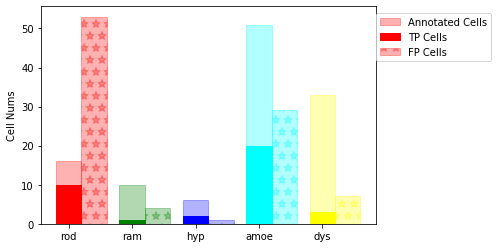

In [42]:
results.resetTPFPWeights()
results.calculateTPFP()
PFscore = results.calculatePFscore()
results.plotTPFPfigure("TPFP.png")

In [43]:
print (PFscore)

8.118516042780747
